In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from tqdm.auto import tqdm

from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    EulerAncestralDiscreteScheduler,
)
import sys

sys.path.append("../.")
from utils.controlnet import call_control_net

In [2]:
# Replace the __call__ method with our custom implementation
StableDiffusionControlNetPipeline.__call__ = call_control_net

# Add dt_latents to callback tensor inputs
StableDiffusionControlNetPipeline._callback_tensor_inputs = [
    "dt_latents",
    "latents",
    "prompt_embeds",
    "negative_prompt_embeds",
]

In [3]:
# Create folder for ../outputs
os.makedirs("../../outputs", exist_ok=True)

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if device == "cuda" else torch.float32

In [4]:
# Set visualization steps (percentage of total steps)
vis_percentages = [0, 30, 60, 100]

# Set model and conditioning types
# control_types = ["canny", "pose", "seg"]

control_types = ["seg"]

prompts = {
    "canny": "A photorealistic recreation of 'Girl with a Pearl Earring', detailed lighting, Vermeer style painting, 8k",
    "seg": "A spacious dance hall with wooden floor, cream colored walls, pendant lamps hanging from the ceiling, and large windows with white curtains letting in natural light, 8k",
    "pose": "A full body portrait of a person standing with arms outstretched, professional photography, studio lighting, 8k",
}

In [5]:
# # Import the PipelineCallback class
# from diffusers.callbacks import PipelineCallback


# # Define custom callbacks for standard and DT visualization
# class VisualizationCallback(PipelineCallback):
#     def __init__(self, percentages, num_inference_steps, visualization_type="standard"):
#         # Define which tensors we want access to
#         self.tensor_inputs = [
#             "latents",
#             "dt_latents",
#             "prompt_embeds",
#             "negative_prompt_embeds",
#         ]
#         self.checkpoints = {}
#         self.visualization_type = visualization_type

#         # Convert percentages to step indices
#         self.percentages = percentages
#         self.checkpoint_indices = [
#             max(0, min(num_inference_steps - 1, int(p * num_inference_steps / 100)))
#             for p in percentages
#         ]

#     def __call__(self, pipe, i, t, callback_kwargs):
#         # Store current latents at checkpoint steps
#         if i in self.checkpoint_indices:
#             percentage = self.percentages[self.checkpoint_indices.index(i)]

#             if self.visualization_type == "standard":
#                 # For standard visualization, we use the noisy latents
#                 latents = callback_kwargs["latents"]
#                 self.checkpoints[percentage] = latents.detach().clone()
#             elif self.visualization_type == "dt" and "dt_latents" in callback_kwargs:
#                 # For DT visualization, we use the predicted denoised latents
#                 dt_latents = callback_kwargs["dt_latents"]
#                 self.checkpoints[percentage] = dt_latents.detach().clone()
#             elif self.visualization_type == "dt":
#                 # Fallback if dt_latents isn't available
#                 print(
#                     f"Warning: dt_latents not available at step {i}. Using a workaround."
#                 )
#                 latents = callback_kwargs["latents"]

#                 # Try to manually predict the denoised image
#                 with torch.no_grad():
#                     # Get the current latent and scale it
#                     latent_model_input = pipe.scheduler.scale_model_input(latents, t)

#                     # Get the prompt embeddings
#                     prompt_embeds = callback_kwargs.get("prompt_embeds")

#                     # Predict noise
#                     noise_pred = pipe.unet(
#                         latent_model_input,
#                         t,
#                         encoder_hidden_states=prompt_embeds,
#                         cross_attention_kwargs=pipe.cross_attention_kwargs,
#                         return_dict=False,
#                     )[0]

#                     # Apply guidance if needed
#                     if (
#                         hasattr(pipe, "do_classifier_free_guidance")
#                         and pipe.do_classifier_free_guidance
#                     ):
#                         noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#                         noise_pred = noise_pred_uncond + pipe.guidance_scale * (
#                             noise_pred_text - noise_pred_uncond
#                         )

#                     # Predict the denoised image
#                     pred_original_sample = pipe.scheduler.step(
#                         noise_pred, t, latents, return_dict=True
#                     ).pred_original_sample

#                     self.checkpoints[percentage] = pred_original_sample

#         return callback_kwargs

In [6]:
# Function to create an interrupt callback at a specific step
def create_interrupt_callback(step):
    def callback(pipeline, i, t, callback_kwargs):
        if i == step:
            pipeline._interrupt = True
        return callback_kwargs

    return callback

In [7]:
# Function to run the pipeline and collect visualizations using dual output
def run_pipeline_with_visualizations(
    pipe, prompt, condition_image, num_inference_steps=50, seed=42
):
    standard_images = {}
    dt_images = {}

    # Get step indices for each percentage
    step_indices = [
        max(0, min(num_inference_steps - 1, int(p * num_inference_steps / 100)))
        for p in vis_percentages
    ]

    # Convert PIL image to RGB if it has alpha channel
    if condition_image.mode == "RGBA":
        condition_image = condition_image.convert("RGB")

    # Run the pipeline for each visualization step
    print(f"Running visualizations for prompt: {prompt}")
    for percentage, step_idx in zip(vis_percentages, step_indices):
        print(f"  Generating visualization at {percentage}%...")

        # Create the interrupt callback for this step
        interrupt_callback = (
            create_interrupt_callback(step_idx) if percentage < 100 else None
        )

        # Create a generator with seed for reproducibility
        generator = torch.Generator(
            device="cuda" if torch.cuda.is_available() else "cpu"
        ).manual_seed(seed)

        # Run the pipeline
        with torch.no_grad():
            pipe._interrupt = False  # Reset interrupt flag

            # Run the pipeline with the "both" visualization type to get both standard and DT outputs
            output = pipe(
                prompt,
                image=condition_image,
                num_inference_steps=num_inference_steps,
                callback_on_step_end=interrupt_callback,
                generator=generator,
            )

            # Get both visualization types from output
            standard_images[percentage] = output.images[0][0]
            dt_images[percentage] = output.images[1][0]

    return standard_images, dt_images, standard_images[100]

In [8]:
# Load all the models
models = {}
for control_type in control_types:
    print(f"Loading {control_type} ControlNet model...")

    # Define the correct model paths based on the control type
    if control_type == "canny":
        model_path = "lllyasviel/sd-controlnet-canny"
    elif control_type == "seg":
        model_path = "lllyasviel/sd-controlnet-seg"
    elif control_type == "pose":
        model_path = "lllyasviel/sd-controlnet-openpose"
    else:
        model_path = f"lllyasviel/sd-controlnet-{control_type}"

    controlnet = ControlNetModel.from_pretrained(model_path, torch_dtype=torch_dtype)

    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "stable-diffusion-v1-5/stable-diffusion-v1-5",
        controlnet=controlnet,
        torch_dtype=torch_dtype,
        safety_checker=None,
        use_safetensors=True,
    )

    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

    if device == "cuda":
        pipe.enable_model_cpu_offload()
    else:
        pipe.to(device)

    models[control_type] = pipe

Loading seg ControlNet model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
# Run visualization for each control type
results = {}
for control_type in control_types:
    print(f"\nProcessing {control_type} ControlNet...")
    pipe = models[control_type]
    prompt = prompts[control_type]

    # Check if condition image exists
    if not os.path.exists(f"../images/conditions/{control_type}.png"):
        print(
            f"Warning: Please make sure the {control_type} image is saved as ../images/conditions/{control_type}.png"
        )
        print(f"Skipping {control_type} processing...")
        continue

    # Load condition image
    try:
        condition_image = Image.open(f"../images/conditions/{control_type}.png")
        # Convert image to RGB if needed
        if condition_image.mode != "RGB":
            condition_image = condition_image.convert("RGB")
    except Exception as e:
        print(f"Error loading {control_type} image: {e}")
        print(f"Skipping {control_type} processing...")
        continue

    # Run pipeline and collect visualizations
    standard_images, dt_images, final_image = run_pipeline_with_visualizations(
        pipe, prompt, condition_image, num_inference_steps=50
    )

    results[control_type] = {
        "standard": standard_images,
        "dt": dt_images,
        "final": final_image,
    }

    # Save individual images
    for percentage, image in standard_images.items():
        image.save(f"../outputs/dt/{control_type}_standard_{percentage}.png")

    for percentage, image in dt_images.items():
        image.save(f"../outputs/dt/{control_type}_dt_{percentage}.png")


Processing seg ControlNet...
Running visualizations for prompt: A spacious dance hall with wooden floor, cream colored walls, pendant lamps hanging from the ceiling, and large windows with white curtains letting in natural light, 8k
  Generating visualization at 0%...


  0%|          | 0/50 [00:00<?, ?it/s]

  Generating visualization at 30%...


  0%|          | 0/50 [00:00<?, ?it/s]

  Generating visualization at 60%...


  0%|          | 0/50 [00:00<?, ?it/s]

  Generating visualization at 100%...


  0%|          | 0/50 [00:00<?, ?it/s]

### Loading Outputs (In case of experiment continuation)

In [10]:
# Import necessary libraries if not already imported
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the control types and visualization percentages (same as before)
control_types = ["canny", "pose", "seg"]
vis_percentages = [0, 30, 60, 100]

In [ ]:
# Create an empty results dictionary to store loaded images
results = {}

# Loop through each control type
for control_type in control_types:
    print(f"Loading {control_type} images...")

    # Initialize dictionaries for this control type
    standard_images = {}
    dt_images = {}

    # Try to load the final image
    final_image_path = f"../outputs/dt/{control_type}_standard_100.png"
    try:
        final_image = Image.open(final_image_path)

        # Load standard images for each percentage
        for percentage in vis_percentages:
            img_path = f"../outputs/dt/{control_type}_standard_{percentage}.png"
            if os.path.exists(img_path):
                standard_images[percentage] = Image.open(img_path)
                print(f"  Loaded standard {percentage}% image")
            else:
                print(f"  Warning: {img_path} not found")

        # Load DT images for each percentage
        for percentage in vis_percentages:
            img_path = f"../outputs/dt/{control_type}_dt_{percentage}.png"
            if os.path.exists(img_path):
                dt_images[percentage] = Image.open(img_path)
                print(f"  Loaded DT {percentage}% image")
            else:
                print(f"  Warning: {img_path} not found")

        # Add to results if images were found
        if standard_images and dt_images:
            results[control_type] = {
                "standard": standard_images,
                "dt": dt_images,
                "final": final_image,
            }
            print(f"Successfully loaded {control_type} images")
        else:
            print(f"Failed to load all {control_type} images")

    except Exception as e:
        print(f"Error loading {control_type} images: {e}")

print(f"\nLoaded results for {len(results)} control types")

Loading canny images...
  Loaded standard 0% image
  Loaded standard 30% image
  Loaded standard 60% image
  Loaded standard 100% image
  Loaded DT 0% image
  Loaded DT 30% image
  Loaded DT 60% image
  Loaded DT 100% image
Successfully loaded canny images
Loading pose images...
  Loaded standard 0% image
  Loaded standard 30% image
  Loaded standard 60% image
  Loaded standard 100% image
  Loaded DT 0% image
  Loaded DT 30% image
  Loaded DT 60% image
  Loaded DT 100% image
Successfully loaded pose images
Loading seg images...
  Loaded standard 0% image
  Loaded standard 30% image
  Loaded standard 60% image
  Loaded standard 100% image
  Loaded DT 0% image
  Loaded DT 30% image
  Loaded DT 60% image
  Loaded DT 100% image
Successfully loaded seg images

Loaded results for 3 control types


### Final Layout

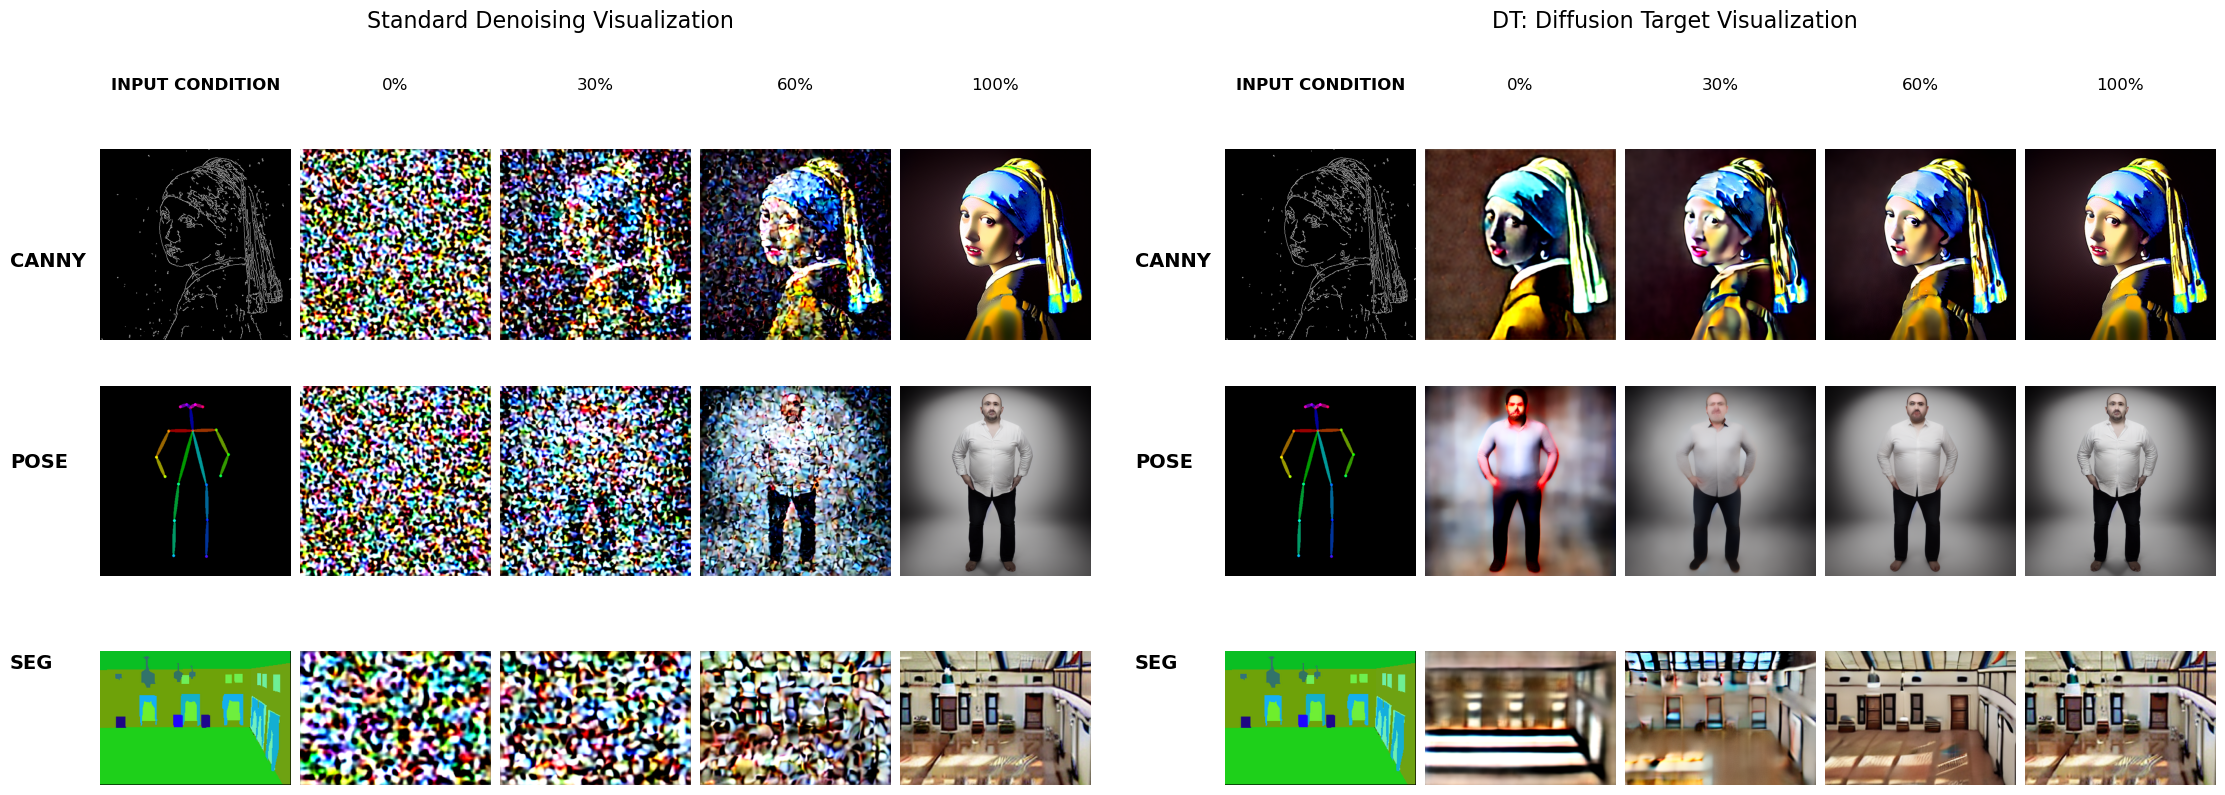

In [ ]:
# Simplified visualization grid with separate subfigures for each section
def create_visualization_grid(results, vis_percentages):
    processed_control_types = list(results.keys())
    if not processed_control_types:
        print(
            "No control types were successfully processed. Cannot create visualization grid."
        )
        return

    nrows = len(processed_control_types)
    ncols = 1 + len(vis_percentages)  # 1 for input condition + vis percentages

    # Create a large figure to hold everything
    fig = plt.figure(figsize=(ncols * 4.5, nrows * 2.5 + 1))

    # Create two gridspecs side by side
    gs = fig.add_gridspec(1, 2, width_ratios=[ncols, ncols])

    # Create two subfigures
    std_fig = fig.add_subfigure(gs[0, 0])
    dt_fig = fig.add_subfigure(gs[0, 1])

    # Create axes grids for each subfigure
    std_axs = std_fig.subplots(
        nrows + 1, ncols, gridspec_kw={"height_ratios": [0.3] + [1] * nrows}
    )
    dt_axs = dt_fig.subplots(
        nrows + 1, ncols, gridspec_kw={"height_ratios": [0.3] + [1] * nrows}
    )

    # Add titles using suptitle
    std_fig.suptitle("Standard Denoising Visualization", fontsize=16)
    dt_fig.suptitle("DT: Diffusion Target Visualization", fontsize=16)

    # Extract header and content axes for each section
    std_header_axes = std_axs[0]
    std_content_axes = std_axs[1:]
    dt_header_axes = dt_axs[0]
    dt_content_axes = dt_axs[1:]

    # Add column headers for standard section
    std_header_axes[0].text(
        0.5,
        0.5,
        "INPUT CONDITION",
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
    )
    std_header_axes[0].axis("off")

    for j, percentage in enumerate(vis_percentages):
        std_header_axes[j + 1].text(
            0.5, 0.5, f"{percentage}%", ha="center", va="center", fontsize=12
        )
        std_header_axes[j + 1].axis("off")

    # Add column headers for DT section (excluding input condition)
    dt_header_axes[0].text(
        0.5,
        0.5,
        "INPUT CONDITION",
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
    )
    dt_header_axes[0].axis("off")

    for j, percentage in enumerate(vis_percentages):
        dt_header_axes[j + 1].text(
            0.5, 0.5, f"{percentage}%", ha="center", va="center", fontsize=12
        )
        dt_header_axes[j + 1].axis("off")

    # Add row labels (control types)
    for i, control_type in enumerate(processed_control_types):
        # Add row label for standard section
        std_fig.text(
            0.02,
            std_content_axes[i, 0].get_position().y0
            + std_content_axes[i, 0].get_position().height / 2,
            control_type.upper(),
            ha="left",
            va="center",
            fontsize=14,
            fontweight="bold",
        )

        # Add row label for DT section
        dt_fig.text(
            0.02,
            dt_content_axes[i, 0].get_position().y0
            + dt_content_axes[i, 0].get_position().height / 2,
            control_type.upper(),
            ha="left",
            va="center",
            fontsize=14,
            fontweight="bold",
        )

    # Populate the grid with images
    for i, control_type in enumerate(processed_control_types):
        # Load input condition image
        condition_image = Image.open(f"../images/conditions/{control_type}.png")
        if condition_image.mode != "RGB":
            condition_image = condition_image.convert("RGB")

        # Ensure all images have the same aspect ratio by using the reference from results
        ref_img = results[control_type]["standard"][vis_percentages[0]]
        ref_aspect = np.array(ref_img).shape[1] / np.array(ref_img).shape[0]

        # Resize input condition image
        condition_array = np.array(condition_image)
        height, width = condition_array.shape[:2]
        new_width = int(height * ref_aspect)
        condition_image = condition_image.resize((new_width, height), Image.LANCZOS)

        # Display input condition in both sections
        std_content_axes[i, 0].imshow(np.array(condition_image))
        std_content_axes[i, 0].axis("off")
        dt_content_axes[i, 0].imshow(np.array(condition_image))
        dt_content_axes[i, 0].axis("off")

        # Add standard visualization images
        for j, percentage in enumerate(vis_percentages):
            std_content_axes[i, j + 1].imshow(
                np.array(results[control_type]["standard"][percentage])
            )
            std_content_axes[i, j + 1].axis("off")

        # Add DT visualization images
        for j, percentage in enumerate(vis_percentages):
            dt_content_axes[i, j + 1].imshow(
                np.array(results[control_type]["dt"][percentage])
            )
            dt_content_axes[i, j + 1].axis("off")

    # Adjust layout
    plt.tight_layout()
    std_fig.subplots_adjust(top=0.93, left=0.1, right=0.98, wspace=0.05, hspace=0.1)
    dt_fig.subplots_adjust(top=0.93, left=0.1, right=0.98, wspace=0.05, hspace=0.1)

    # Save and show
    plt.savefig("../outputs/dt/visualization_grid.png", dpi=300, bbox_inches="tight")
    plt.show()


# Call the function with your results
create_visualization_grid(results, vis_percentages)